In [1]:
import numpy as np
import pandas as pd
import keras
import joblib
import tensorflow as tf
import model_keras.recommender_model as recommender_model
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

pd.set_option('display.max_colwidth', 150)

### Recommending movies for new user

In [18]:
movies_encoded_by_genre = pd.read_csv('csv_files/movies_encoded_by_genre_big.csv')

# Filtering movies by number of ratings
MIN_NUM_RATINGS = movies_encoded_by_genre['num_ratings'].quantile(0.8)

In [11]:
model = keras.models.load_model('model_keras/content_based_recommender.keras', custom_objects={'NormLayer' : recommender_model.NormLayer})

#### New user vector

In [12]:
new_user_id = 5000
new_avg_user_rating = 0.0
new_action = 5.0
new_adventure = 5.0
new_animation = 1.0
new_children = 0.0
new_comedy = 1.0
new_crime = 2.0
new_documentary = 2.0
new_drama = 1.0
new_fantasy = 4.0
new_horror = 0.0
new_musical = 1.0
new_mystery = 3.5
new_romance = 1.0
new_scifi = 5.0
new_thriller = 2.0
new_war = 3.0
new_western = 3.0

user_vec = np.array([new_user_id, new_avg_user_rating,
                       new_action, new_adventure, new_animation, new_children,
                       new_comedy, new_crime, new_documentary,
                       new_drama, new_fantasy, new_horror,
                       new_musical, new_mystery,
                       new_romance, new_scifi, new_thriller,
                       new_war, new_western])

user_vec

array([5.0e+03, 0.0e+00, 5.0e+00, 5.0e+00, 1.0e+00, 0.0e+00, 1.0e+00,
       2.0e+00, 2.0e+00, 1.0e+00, 4.0e+00, 0.0e+00, 1.0e+00, 3.5e+00,
       1.0e+00, 5.0e+00, 2.0e+00, 3.0e+00, 3.0e+00])

#### Movies vector based on genre and IMDB's weighted rating formula

In [13]:
def imdb_weighted_rating(v, r, c):
    '''
    This function calculates the IMDB's weighted rating for a movie
    Parameters:
    v : number of votes for the movie
    r : average rating of the movie
    c : mean vote across the whole report
    '''
    m = MIN_NUM_RATINGS

    return (r*v/(v+m))+(c*m/(v+m))

def gen_movie_vecs(movies_df, year_filter=2000,top_movies=50):
    movies_vecs = movies_df.drop(columns=['title'])
    movies_vecs.rename(columns={'movieId' : '[movieId]', 'num_ratings':'[num_ratings]', 'avg_movie_rating':'[avg_movie_rating]'}, inplace=True)

    # Adding IMDB's wheighted rating
    c = movies_vecs['[avg_movie_rating]'].mean()
    movies_vecs['imdb_rating'] = imdb_weighted_rating(movies_vecs['[num_ratings]'], movies_vecs['[avg_movie_rating]'], c).round(2)

    # Filtering by movie year
    year_filter = year_filter
    movies_vecs = movies_vecs[movies_vecs['year'] >= year_filter]

    # Filtering by favorite genres
    movies_vecs.sort_values('imdb_rating', ascending=False, inplace=True)
    aux = pd.DataFrame()
    for i in range(len(user_vec[2:])):
        genre_rate = user_vec[i+2]
        offset = 4
        column = movies_vecs.columns[offset+i]
        if genre_rate >= 3:
            subset = movies_vecs[movies_vecs[column] == 1].head(top_movies)
            aux = pd.concat([aux, subset], axis=0)

    aux = pd.concat([aux, movies_vecs.head(100)], axis=0)

    movies_vecs = aux.drop_duplicates().drop(columns=['imdb_rating'])


    return movies_vecs

def gen_user_vecs(user_vec, movies_vecs):
    user_cols = ['[userId]', '[avg_user_rating]', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western']
    return pd.DataFrame([user_vec]*len(movies_vecs), columns = user_cols)

In [23]:
USER_COLS = ['[userId]', '[avg_user_rating]', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western']
k = {x:0.0 for x in USER_COLS}
k.keys()

dict_keys(['[userId]', '[avg_user_rating]', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

#### Predicting ratings on NN

In [14]:
scalerUser = joblib.load('scalers/scalerUser.gz')
scalerMovies = joblib.load('scalers/scalerMovies.gz')
scalerTarget = joblib.load('scalers/scalerTarget.gz')

In [15]:
# generate and replicate the user vector to match the number movies in the data set.
movies_vecs = gen_movie_vecs(movies_encoded_by_genre, year_filter=2015)
user_vecs = gen_user_vecs(user_vec, movies_vecs)

# scale our user and item vectors
suser_vecs = scalerUser.transform(user_vecs)
smovies_vecs = scalerMovies.transform(movies_vecs)

# make a prediction
y_p = model.predict([suser_vecs[:, 2:], smovies_vecs[:, 3:]])

# unscale y prediction 
y_pu = scalerTarget.inverse_transform(y_p)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


#### Output

In [16]:
recommendations = pd.merge(movies_vecs['[movieId]'], movies_encoded_by_genre[['movieId','title', 'avg_movie_rating']], left_on='[movieId]', right_on='movieId')
recommendations = pd.concat([recommendations,pd.DataFrame(y_pu.round(2), columns=['y_pu'])],axis=1)

output = recommendations[['movieId','title', 'avg_movie_rating', 'y_pu']].sort_values('y_pu',ascending=False).reset_index(drop=True)
output.head(10)

,movieId,title,avg_movie_rating,y_pu
0,188301,Ant-Man and the Wasp (2018),3.47,4.59
1,122882,Mad Max: Fury Road (2015),3.87,4.59
2,254726,Dune (2021),3.99,4.58
3,263007,Spider-Man: No Way Home (2021),3.81,4.58
4,243642,Zack Snyder's Justice League (2021),3.48,4.58
5,163056,Shin Godzilla (2016),3.58,4.56
6,166528,Rogue One: A Star Wars Story (2016),3.78,4.56
7,184257,Making a Murderer (2015),3.95,4.56
8,173145,War for the Planet of the Apes (2017),3.52,4.56
9,122886,Star Wars: Episode VII - The Force Awakens (2015),3.63,4.55


#### Adding IMDB links and PDF export

In [112]:
links_df = pd.read_csv('ml-latest/links.csv')

links_df['imdb_url'] = links_df['imdbId'].apply(lambda x: "https://www.imdb.com/title/tt"+ str(x) + "/")

output = pd.merge(output, links_df[['movieId','imdb_url']], on='movieId')

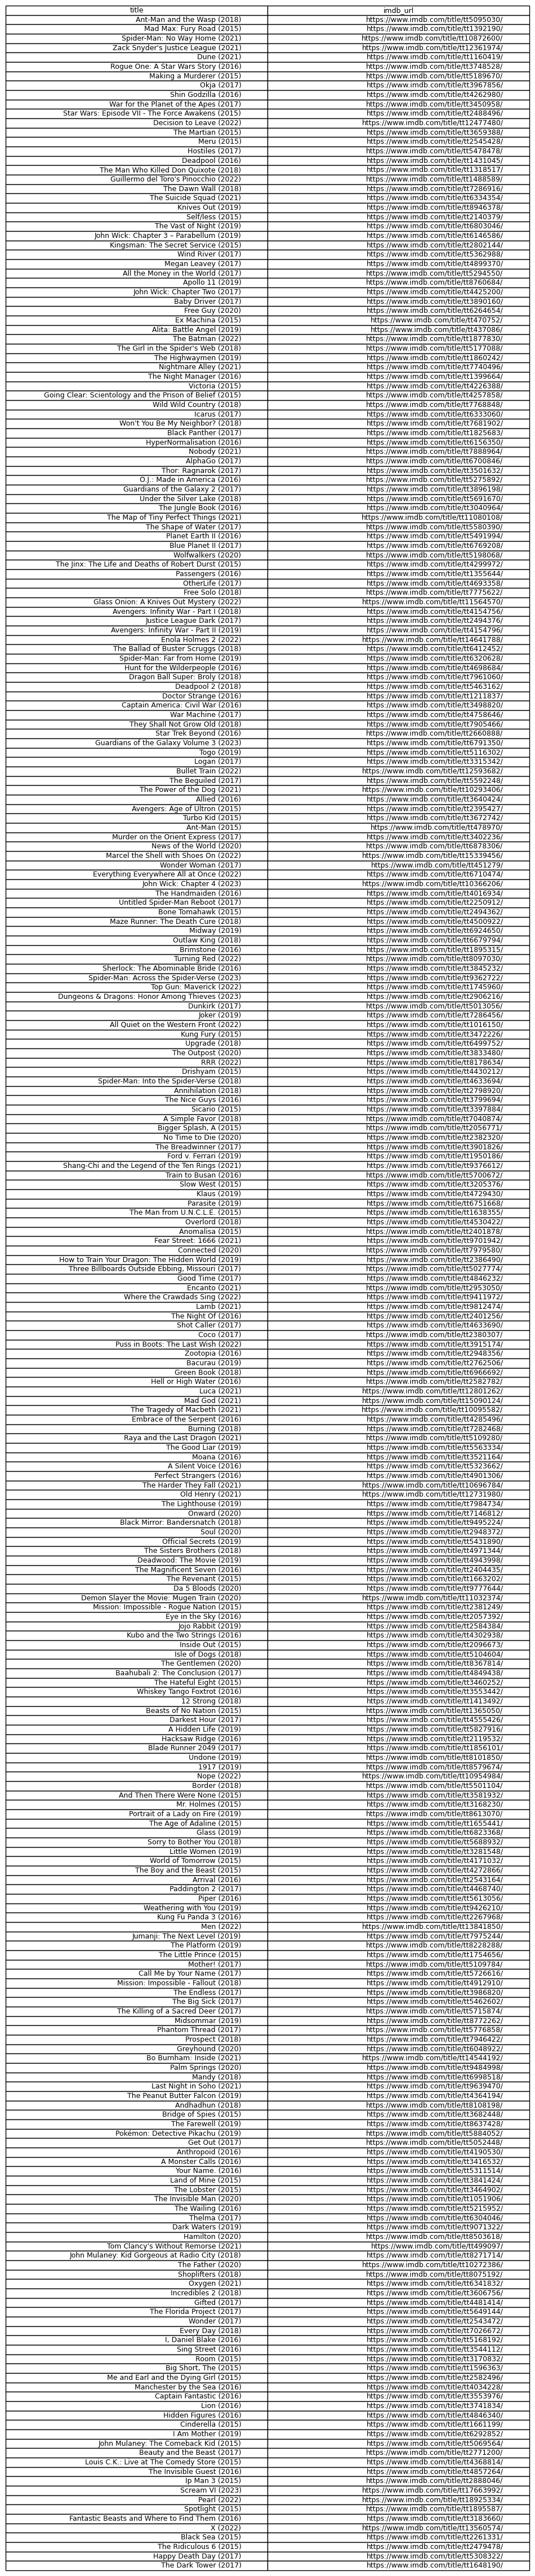

In [113]:
#PDF Export
fig, ax =plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=output[['title', 'imdb_url']].values,colLabels=output[['title','imdb_url']].columns,loc='center')

pp = PdfPages("recommendations.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()